## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import autocorrect
import emoji
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report , confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\CHARISHMA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Loading dataset

In [2]:
dd = pd.read_csv(r"C:\Users\CHARISHMA\Internship\Experiment Tracking\data.csv")

In [3]:
dd

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


## EDA

In [4]:
dd.drop(dd[dd['Review text'].isna()].index, inplace=True)

In [5]:
dd.isna().sum()

Reviewer Name        2
Review Title         2
Place of Review     42
Up Votes             2
Down Votes           2
Month              457
Review text          0
Ratings              0
dtype: int64

In [6]:
dd.duplicated().sum()

0

In [7]:
dd['Ratings'].value_counts(normalize=True).sort_index()

Ratings
1    0.090012
2    0.035958
3    0.072268
4    0.204935
5    0.596827
Name: proportion, dtype: float64

<Axes: xlabel='Ratings'>

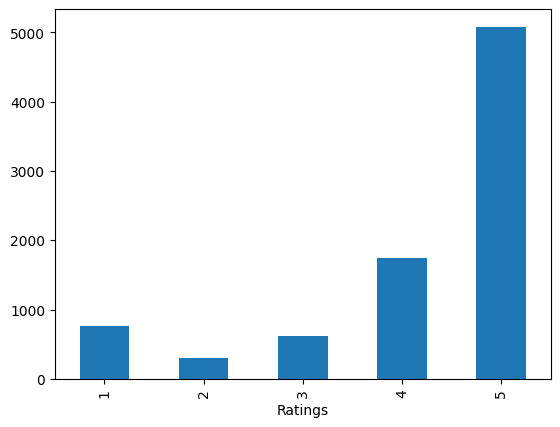

In [8]:
dd['Ratings'].value_counts().sort_index().plot(kind = 'bar')

## Sentiment analysis on text data

In [9]:
sid = SentimentIntensityAnalyzer()

In [10]:
def sentiment_nltk(text):
    # Check if the text is not NaN
    if isinstance(text, str):
        scores = sid.polarity_scores(text)
        if scores['compound'] > 0:
            return 'Positive'
        elif scores['compound'] < 0:
            return 'Negative'
        else:
            return 'Neutral'
    else:
        return 'Neutral'

In [11]:
dd['Sentiment'] = dd['Review text'].apply(sentiment_nltk)

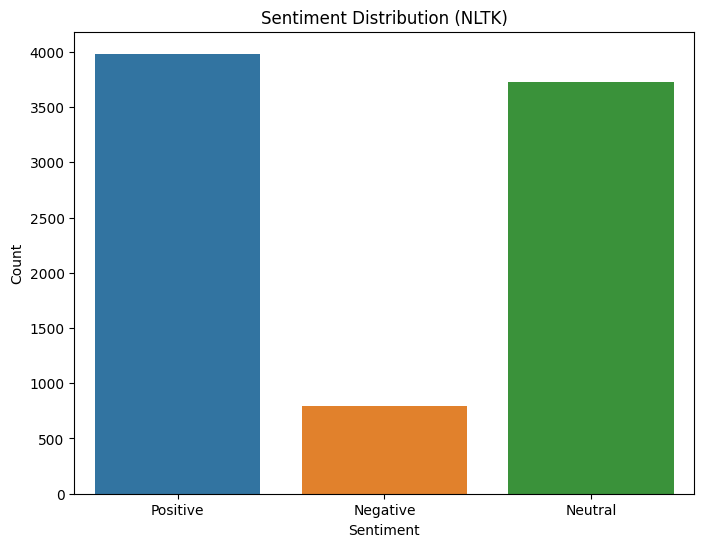

In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=dd)
plt.title('Sentiment Distribution (NLTK)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [13]:
dd['Sentiment'].value_counts(normalize=True)

Sentiment
Positive    0.468038
Neutral     0.438308
Negative    0.093655
Name: proportion, dtype: float64

In [14]:
dd = dd[dd["Sentiment"] != "Neutral"]

dd.shape

(4780, 9)

In [15]:
dd["Sentiment"].value_counts(normalize=True)

Sentiment
Positive    0.833264
Negative    0.166736
Name: proportion, dtype: float64

In [16]:
dd['Sentiment_num'] = dd['Sentiment'].map({'Positive': 1, 'Negative': 0})

In [17]:
dd.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,Sentiment,Sentiment_num
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,Positive,1
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,Negative,0
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,Negative,0
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3,Positive,1
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,Positive,1


In [18]:
dd = dd[["Review text", "Sentiment_num"]] 
dd.head()

,Review text,Sentiment_num
0,"Nice product, good quality, but price is now r...",1
1,They didn't supplied Yonex Mavis 350. Outside ...,0
2,Worst product. Damaged shuttlecocks packed in ...,0
3,"Quite O. K. , but nowadays the quality of the...",1
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1


## Splitting Dataset

In [19]:
x = dd[['Review text']]
y = dd['Sentiment_num']

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.2, random_state=33)

## Data Preprocessing

In [21]:
def preprocess(raw_text):
    # Removing special characters and digits
    sentence = re.sub("[^a-zA-Z]", " ", raw_text)

    # change sentence to lower case
    sentence = sentence.lower()

    # tokenize into words
    tokens =nltk.word_tokenize(sentence)

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]

     # Join and return
    return " ".join(filtered_tokens)

In [22]:
from tqdm import tqdm, tqdm_notebook

In [23]:
tqdm.pandas()

In [24]:
x_train = x_train['Review text'].progress_apply(lambda x: preprocess(x))
x_test = x_test['Review text'].progress_apply(lambda x: preprocess(x))

100%|██████████████████████████████████████████████████████████████████████████████| 956/956 [00:00<00:00, 3057.69it/s]


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
vector = CountVectorizer(preprocessor=preprocess)

%time x_train_numeric = vector.fit_transform(x_train)

print(x_train_numeric.shape)

CPU times: total: 1.03 s
Wall time: 1.71 s
(3824, 2282)


In [27]:
%time x_test_numeric = vector.transform(x_test)

print(x_test_numeric.shape)

CPU times: total: 141 ms
Wall time: 480 ms
(956, 2282)


In [28]:
from wordcloud import WordCloud

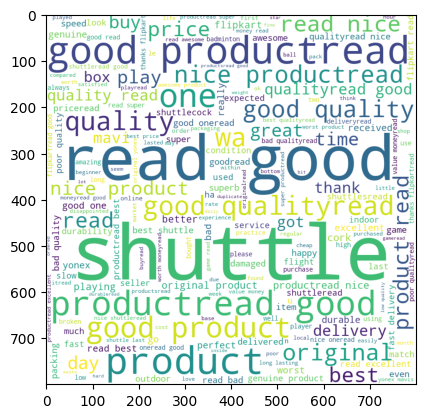

In [29]:
train_text = ' '.join(x_train)

data = WordCloud(height=800,width=800,background_color='white').generate(train_text)
plt.imshow(data)

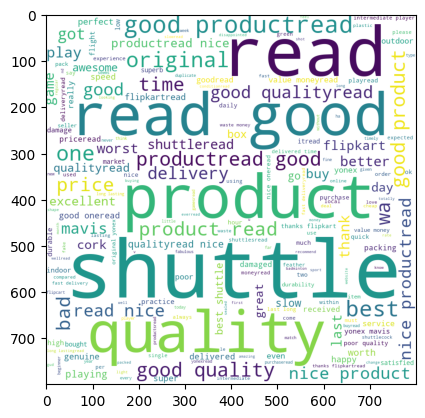

In [30]:
test_text = ' '.join(x_test)

data = WordCloud(height=800,width=800,background_color='white').generate(test_text)
plt.imshow(data)

# MLFlow¶

In [31]:
import mlflow

In [32]:
mlflow.set_experiment("Emotion Detection on Flipkart Reviews")

2024/03/27 16:22:33 INFO mlflow.tracking.fluent: Experiment with name 'Emotion Detection on Flipkart Reviews' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/CHARISHMA/Internship/Experiment%20Tracking/mlruns/877977494796154616', creation_time=1711536753422, experiment_id='877977494796154616', last_update_time=1711536753422, lifecycle_stage='active', name='Emotion Detection on Flipkart Reviews', tags={}>

# Creating an Optimal Workflow

In [33]:
pipe = Pipeline(
    [
        ('vectorization', CountVectorizer()),
        ('nb', MultinomialNB())
    ]
)

MAX_FEATURES = [1000, 1500, 2000]
ALPHA = [1, 10]

# Observe the Key Value Pair format
parameter_grid = [{'vectorization__preprocessor' : [preprocess],
                   'vectorization__max_features' : MAX_FEATURES,
                   'nb__alpha' : ALPHA}]


In [34]:
clf = GridSearchCV(
    estimator=pipe,
    param_grid=parameter_grid,
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)

mlflow.sklearn.autolog(max_tuning_runs=None)

with mlflow.start_run() as run:
    %time clf.fit(x_train, y_train)

y_test_pred = clf.predict(x_test)
pos_label = 1 
test_f1_score = f1_score(y_test, y_test_pred, pos_label=pos_label)
print('Score on Test Data:', test_f1_score)

y_train_pred = clf.predict(x_train)
pos_label = 1  
train_f1_score = f1_score(y_train, y_train_pred, pos_label=pos_label)
print('Score on Train Data:', train_f1_score)

2024/03/27 16:22:34 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logged at level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2024/03/27 16:22:34 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 59.2 s
Wall time: 1min 55s


2024/03/27 16:24:29 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Score on Test Data: 0.9670192906036092


2024/03/27 16:24:31 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Score on Train Data: 0.9724770642201835


In [35]:
import joblib
from joblib import Memory

import os

In [36]:
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory),
    'knn' : Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', KNeighborsClassifier())
    ], memory=memory),
    'svc' : Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', SVC())
    ], memory=memory)
}

param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['elasticnet'],
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ],
    'knn': [
        {
            'vectorization': [CountVectorizer()],
            'classifier__n_neighbors' : [i for i in range(3, 21, 2)], 
            'classifier__p' : [1, 2, 3]
        }
    ],
    'svc': [
        {
            'vectorization': [CountVectorizer()],
            'classifier__kernel' : ['rbf'], 
            'classifier__C' : [0.1, 0.01, 1, 10, 100]
        }, 
        {
            'vectorization': [CountVectorizer()],
            'classifier__kernel' : ['poly'], 
            'classifier__degree' : [2, 3, 4, 5], 
            'classifier__C' : [0.1, 0.01, 1, 10, 100]
        }, 
        {
            'vectorization': [CountVectorizer()],
            'classifier__kernel' : ['linear'], 
            'classifier__C' : [0.1, 0.01, 1, 10, 100]
        }
    ]
}


In [37]:
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo],
                               param_grid=param_grids[algo],
                               cv=5,
                               scoring='f1',
                               return_train_score=True,
                                   verbose=1
                                  )
    mlflow.sklearn.autolog(max_tuning_runs=None)

    with mlflow.start_run() as run:
        %time grid_search.fit(x_train, y_train)

    best_models[algo] = grid_search.best_estimator_

    y_test_pred = grid_search.predict(x_test)
    pos_label = 1  
    test_f1_score = f1_score(y_test, y_test_pred, pos_label=pos_label)
    print('Score on Test Data: ', test_f1_score)
    
    y_train_pred = grid_search.predict(x_train)
    pos_label = 1  
    train_f1_score = f1_score(y_train, y_train_pred, pos_label=pos_label)
    print('Score on Train Data:', train_f1_score)

********** naive_bayes **********


2024/03/27 16:24:31 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


2024/03/27 16:24:49 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2024/03/27 16:24:49 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


CPU times: total: 5.2 s
Wall time: 17.4 s
Score on Test Data:  0.9670192906036092
Score on Train Data: 0.9724770642201835
********** decision_tree **********


2024/03/27 16:24:49 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


2024/03/27 16:25:22 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2024/03/27 16:25:22 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


CPU times: total: 15.6 s
Wall time: 33.2 s
Score on Test Data:  0.9559902200488998
Score on Train Data: 0.9687025220297781
********** logistic_regression **********


2024/03/27 16:25:22 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


2024/03/27 16:30:11 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2024/03/27 16:30:11 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.
2024/03/27 16:30:12 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


CPU times: total: 3min 12s
Wall time: 4min 48s
Score on Test Data:  0.962822936357908
Score on Train Data: 0.9816455696202532
********** knn **********
Fitting 5 folds for each of 27 candidates, totalling 135 fits


2024/03/27 16:31:12 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


CPU times: total: 1min
Wall time: 1min
Score on Test Data:  0.9441441441441442


2024/03/27 16:31:13 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Score on Train Data: 0.9569277108433735
********** svc **********


2024/03/27 16:31:13 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


2024/03/27 16:33:08 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


CPU times: total: 1min 27s
Wall time: 1min 54s
Score on Test Data:  0.9609423434593924


2024/03/27 16:33:08 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Score on Train Data: 0.9908085371553201


In [38]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1500)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=1500)),
                ('classifier', DecisionTreeClassifier(max_depth=10))])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.4,
                                    penalty='elasticnet', solver='saga'))])

knn
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer()),
                ('classifier', KNeighborsClassifier())])

svc
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer()),
         

In [39]:
from sklearn import metrics

# Create the directory if it doesn't exist
if not os.path.exists('best_models'):
    os.makedirs('best_models')

for name, model in best_models.items():
    print("*"*10, name, "*"*10)

    # Save the model
    joblib.dump(model, f'best_models/{name}.pkl')

    # Load the model
    model = joblib.load(f'best_models/{name}.pkl')

    # Predict Test
    %time y_test_pred = model.predict(x_test)

    # Calculate F1 score with correct positive label
    pos_label = 1  
    test_f1_score = metrics.f1_score(y_test, y_test_pred, pos_label=pos_label)

    print("Test Score (F1):", test_f1_score)
    
    # Predict Train
    %time y_train_pred = model.predict(x_train)

    # Calculate F1 score with correct positive label
    pos_label = 1 
    train_f1_score = metrics.f1_score(y_train, y_train_pred, pos_label=pos_label)

    print("Train Score (F1):", train_f1_score)

    # Print model size
    print("Model Size:", os.path.getsize(f'best_models/{name}.pkl'), "Bytes")

********** naive_bayes **********
CPU times: total: 15.6 ms
Wall time: 14.1 ms
Test Score (F1): 0.9670192906036092
CPU times: total: 31.2 ms
Wall time: 30.9 ms
Train Score (F1): 0.9724770642201835
Model Size: 104502 Bytes
********** decision_tree **********
CPU times: total: 15.6 ms
Wall time: 11.8 ms
Test Score (F1): 0.9559902200488998
CPU times: total: 0 ns
Wall time: 34 ms
Train Score (F1): 0.9687025220297781
Model Size: 83148 Bytes
********** logistic_regression **********
CPU times: total: 15.6 ms
Wall time: 10 ms
Test Score (F1): 0.962822936357908
CPU times: total: 31.2 ms
Wall time: 32.9 ms
Train Score (F1): 0.9816455696202532
Model Size: 77561 Bytes
********** knn **********
CPU times: total: 78.1 ms
Wall time: 121 ms
Test Score (F1): 0.9441441441441442
CPU times: total: 344 ms
Wall time: 470 ms
Train Score (F1): 0.9569277108433735
Model Size: 303827 Bytes
********** svc **********
CPU times: total: 0 ns
Wall time: 50.6 ms
Test Score (F1): 0.9609423434593924
CPU times: total: 1